# Milestone 2 Assignment - Capstone Check-in

## Author - Logan Downing

Datasci 420  
Aug 14, 2018

![](http://drivendata.materials.s3.amazonaws.com/pumps/pumping.jpg)
# Project Goal - Data Mining the Water Table



Data from the Tanzanian Ministry of Water reveals the working state of thousands of water pumps across that country. The data include a plethora of features including pump age, type of management, cost of water and water source. The working state of each pump is included. Importantly, latitude and longitude of each pump are provided.

**Business problem**  
The challenge is to determine, given the characteristics of each water pump, whether you can predict which pumps are faulty. "A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania." (DrivenData.org)

# Data Sources
Our base data come from the Tanzanian Ministry of Water via the DrivenData.org website:

* https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/

We add to that precipitation data from a U.S. modeling effort that estimates precipitation values:

* https://globalweather.tamu.edu/

We join the two datasets on latitude/longitude. The hypothesis here is that natural precipitation may affect the working state of water pumps because of their connection to agriculture (naturally rainy locations probably won't rely on pumps as much), and mechanical dependency (the operation of pumps in drier locations may be adversely affected by drought).

# Methodology
The determination of whether a pump is working or not is clearly a classification problem. We'll use machine learning models based on classification for the final algorithm that predicts the working state of the water pumps.

### Modeling approaches
We'll use several machine learning models to evaluate the outcomes, selecting the best performing model as our final product.

1. **Logistic regression**. Classic linear approach to classification. Our performance metrics will be F1 score and AUC value.

2. **Support vector machines**. This will be an interesting one to compare to logistic regression. SVM creates a separation boundary between outcome classes in multiple dimensions, and has the power to work in many dimensions. The performance metric will be F1 score.

3. **CART (Decision Trees)**. Finally, let's apply a Random Forest approach, since this modeling is squarely classification. The performance metric will be F1 score and AUC value.

# Processing Steps
Here let's get a high-level view of how we'll approach our project from data ingestion to model predictions. We stay at the broad outlines since we've already completed much of the data processing in the previous milestone (M01), and will take on the additional steps of feature selection, model building and model evaluation in this notebook.

## 1. Data acquisition and preparation
### Load base data
We start with two data sources:

1. The base water pump dataset provided by the Tanzanian Ministry of Water.

2. Precipitation data from a U.S.modeling effort that estimates precipitation values across the country.

### Discard certain features
Here we look at the features of the water pump dataset and discard those that:

1. Have too many categorical values
2. Contain values that are not predictive
3. Are missing latitude and longitude values (needed to join the precipitation data)
4. Are duplicative fields

### Create new fields based on existing data
We create new fields derived from existing water pump data:

1. Pump age is a derivation of data record date and pump installation year.

### Filter the outcome variable
There are three outcomes for water pump data (working, working but needs repair, and not working). We'll focus on just the working and the not working cases, since those are our desired predictions. The third category (working needs repair) is much less prevalent anyway.

### Join water pump data and precipitation data
Since our water pump data have latitude and longitude values, it's an easy matter to join it with the modeling data which is also indexed on the same values.

## 2. Feature engineering
Here we take a look at the distributions of our features to get a sense of their contributions towards the final predictive outcomes. We'll take certain steps to transform features according to their membership, skewness and/or idiosynchratic behavior.

### Handle outliers
Winsorize and/or discard outliers that may artificially influence outcomes.

### Transform fields
Some continuous fields may profit from being log transformed, should they exhibit strong log behavior. We'll also risk encode one categorical field which has many values.

### Bin continuous variables
In some cases, we'll need to create bins of continuous variables in order to reduce overfitting.

### Combine and/or discard values in categorical fields
We have a number of categorical fields which may exhibit strongly skewed or lopsided distributions. In this step we'll:

1. Discard underrepresented values
2. Combine some categorical values with others (unify)

### Scale predictors
We'll apply MinMax and/or Standard Scaling on our fields to create parity among all our predictors.


## 3. Feature selection
In this section we'll examine our library of features to discover which are likely the best predictors of outcomes.

### Correlations
We'll examine features to see which are likely most predictive of outcome. Also, we'll determine which features may be correlated with each other.

### Determination of best features
We'll extend our correlation work with several approaches to determine the best set of features for our model.

1. Random Forest approach to discover the top features, using feature importances. 
2. Forward and/or backward feature selection.
3. LASSO regression approach to feature selection.

This work will provide us the best set of recommended features to use for our modeling work and evaluation.


## 4. Modeling and performance evaluation
In this step we'll create machine learning models based on three modeling approaches: logistic regression, SVM and Decision Trees. Using performance metrics we can identify the best performing model for our continued work.

### Create test, train and validate data
We have 10's of thousands of datapoints, and thus have the flexibility to use fairly large populations for our test, train and validation data:

1. Train (60% of all observations) & validate (20%).
2. Test (20%)

The validate dataset can be used within each modeling approach to help select hyperparameters. The test dataset will act as holdout, and be the final arbiter of performance (M03).

### Performance metrics
We'll use a combination of metrics appropriate for each modeling approach:

* F1-score
* AUC

# Step 1. Acquire and preprocess data
In this section we read in the data we've already processed in the previous milestone (M01), and continue with a bit of processing of its features.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from time import time
time00=time() # overall timing of entire notebook (see end)

In [2]:
# data are located locally. this dataset is the outcome of M01 assignment.
f = 'data/LoganDowning-M01-dataset.csv'
df = pd.read_csv(f, header=0, index_col=0)
#df.head()

Drop features that are not necessary and/or not predictive

In [3]:
# the id column is immaterial to predicting outcomes
df.drop('id',axis=1,inplace=True)

# date_recorded and construction_year have already been used to create the 'age' column
df.drop('date_recorded',axis=1,inplace=True)
df.drop('construction_year',axis=1,inplace=True)

df.head()

gps_height  longitude  latitude            basin  region_code  \
0         805  29.607122 -4.906265  Lake Tanganyika           16   
1         783  29.607201 -4.903016  Lake Tanganyika           16   
2         783  29.610321 -4.912941  Lake Tanganyika           16   
3         793  29.610965 -4.906904  Lake Tanganyika           16   
4         783  29.611947 -4.837695  Lake Tanganyika           16   

   district_code  population  public_meeting  permit extraction_type_class  \
0              4         750               0       1                 other   
1              4        3500               1       1              handpump   
2              4        3500               0       1                 other   
3              4          10               0       1                 other   
4              3         150               1       1               gravity   

  management_group payment_type quality_group quantity_group   source_type  \
0            other   per bucket          good            dry    river/lake   
1       user-group      monthly          good         enough  shallow well   
2            other   per bucket          good            dry    river/lake   
3            other   per bucket          good            dry    river/lake   
4       user-group      unknown          good   insufficient        spring   

  source_class waterpoint_type_group  status_group  age    precip  
0      surface    communal standpipe             0   42  7.046578  
1  groundwater             hand pump             1    3  7.046578  
2      surface    communal standpipe             0   42  7.046578  
3      surface    communal standpipe             0   42  7.046578  
4  groundwater    communal standpipe             0    5  7.046578

In [4]:
df.describe()

gps_height     longitude      latitude   region_code  district_code  \
count  36163.000000  36163.000000  36163.000000  36163.000000   36163.000000   
mean     998.261842     36.069394     -6.268292     15.673672       6.060449   
std      625.295640      2.480055      2.766376     21.057694      10.846442   
min      -63.000000     29.607122    -11.586297      2.000000       1.000000   
25%      358.500000     34.710834     -8.785826      4.000000       2.000000   
50%     1153.000000     36.666470     -6.149652     10.000000       3.000000   
75%     1492.000000     37.856502     -3.634137     16.000000       5.000000   
max     2628.000000     40.345193     -1.042375     99.000000      63.000000   

         population  public_meeting        permit  status_group           age  \
count  36163.000000    36163.000000  36163.000000  36163.000000  36163.000000   
mean     319.717667        0.921190      0.725686      0.600171     15.226779   
std      727.895066        0.269445      0.446174      0.489870     12.484459   
min       10.000000        0.000000      0.000000      0.000000     -7.000000   
25%       50.000000        1.000000      0.000000      0.000000      4.000000   
50%      150.000000        1.000000      1.000000      1.000000     13.000000   
75%      250.000000        1.000000      1.000000      1.000000     25.000000   
max     7500.000000        1.000000      1.000000      1.000000     53.000000   

             precip  
count  36163.000000  
mean       3.959921  
std        3.122670  
min        0.128127  
25%        1.930011  
50%        3.284445  
75%        5.210692  
max       17.731944

In [5]:
# tuck away a copy of the raw data for convenience:
df0 = df.copy()

# Step 2. Feature engineering
Review the independent variables and see whether their distributions need any attention beyond that already done in the previous milestone (M01).

## Continuous fields
We'll look at the fields that are continuously-valued in this section:

* gps_height
* population
* age
* precipitation


In [6]:
def plot_hist(data,field="",title="",xlabel="",color='C0'):
    #ax=plt.figure(figsize=(12,6)).gca()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.hist(data,bins=30,edgecolor='silver',color=color)

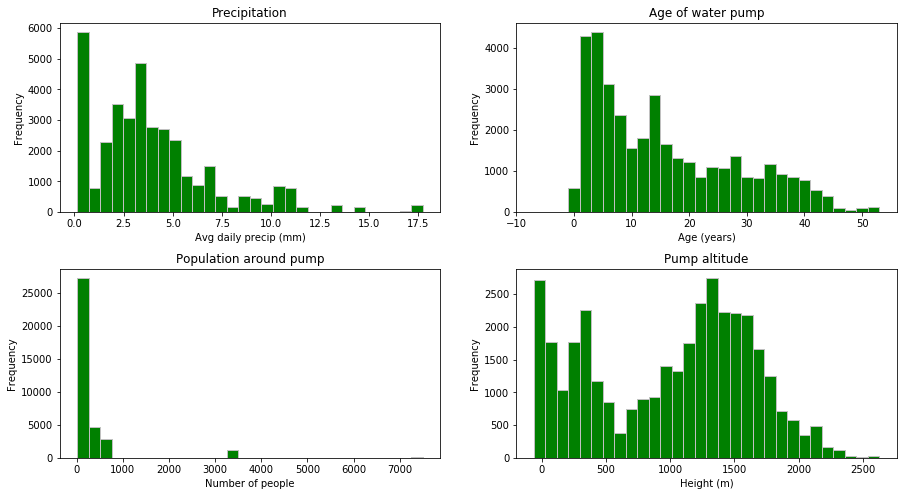

In [7]:
fig,axes=plt.subplots(2,2,figsize=(15,8))
plt.subplots_adjust(hspace=.3)

# precip
plt.axes(axes[0,0])
plot_hist(df.precip,title="Precipitation",xlabel="Avg daily precip (mm)",color='green')

# age
plt.axes(axes[0,1])
plot_hist(df.age,title="Age of water pump",xlabel="Age (years)",color='green')

# population
plt.axes(axes[1,0])
plot_hist(df.population,title="Population around pump",xlabel="Number of people",color='green')

# gps_height
plt.axes(axes[1,1])
plot_hist(df.gps_height,title="Pump altitude",xlabel="Height (m)",color='green')

#### Precipitation field
We've got a modest right skew on the precipitation field, which could benefit from log transformation.

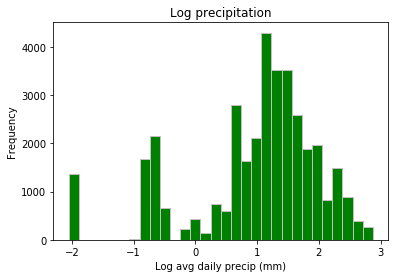

In [8]:
# assign the log value to precip field (use df0 for idempotency)
df.precip = np.log(df0.precip)
plot_hist(df.precip,title="Log precipitation",xlabel="Log avg daily precip (mm)",color='green')


#### Population field 
The population field was already binned into a discrete number of values in the previous milestone (M01):

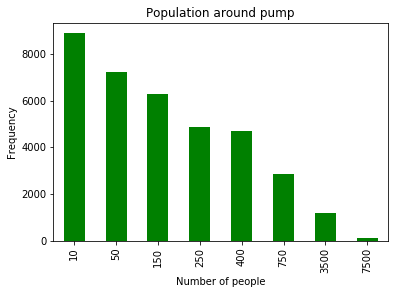

In [9]:
df.population.value_counts().plot(kind='bar', color='green')
plt.ylabel("Frequency")
plt.xlabel("Number of people")
plt.title("Population around pump")
_=""

Let's merge the last two bins, because once a population hits the 1000's, the pump is already highly subscribed.

In [10]:
df.loc[df.population==7500,'population'] = 3500
df.population.value_counts()

10      8890
50      7241
150     6283
250     4884
400     4697
750     2871
3500    1297
Name: population, dtype: int64

## Categorical fields

Next let's look at fields that are categorical. We'll look at these fields to get a sense of their distributions and turn them into numeric feature values for subsequent modeling.

* basin
* extraction_type_class
* management_group
* payment_type
* quality_group
* quantity_group
* source_type
* source_class
* region_code
* district_code
* waterpoint_type_group


In [11]:
def plot_cat(data,field,title="",color="C0"):
    plt.title(title or field)
    plt.ylabel("Frequency")
    data[field].value_counts().plot(kind='bar',color=color)

def plot_two(data,field1,field2="",color='C0'):    
    fig,axes=plt.subplots(1,2,figsize=(15,6))
    plt.subplots_adjust(hspace=.3)

    # 1
    plt.axes(axes[0])
    plot_cat(data,field1,color=color)

    # 2
    if field2:
        plt.axes(axes[1])
        plot_cat(data,field2,color=color)    

#### Basin and extraction_type_class

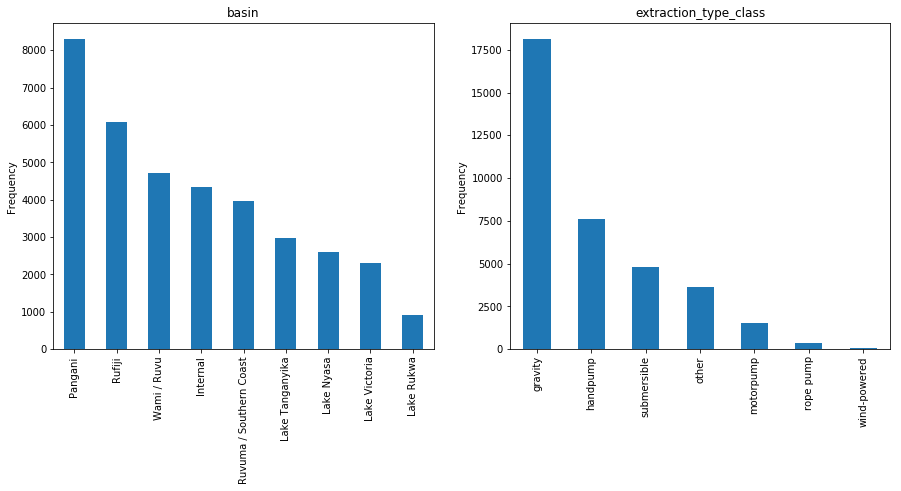

In [12]:
plot_two(df,'basin','extraction_type_class')


In [13]:
# we'll need to one-hot encode the basin field
df=pd.get_dummies(df,drop_first=False,columns=['basin'])
# drop the least populated category to avoid over-correlation
df.drop('basin_Lake Rukwa',axis=1,inplace=True)

# we'll need to one-hot encode the extraction_type_class field
df=pd.get_dummies(df,drop_first=False,columns=['extraction_type_class'],prefix="type")
# drop one of the encoded fields for extraction_type_class to avoid over-correlation
df.drop('type_wind-powered',axis=1,inplace=True)

#### management_group and payment_type

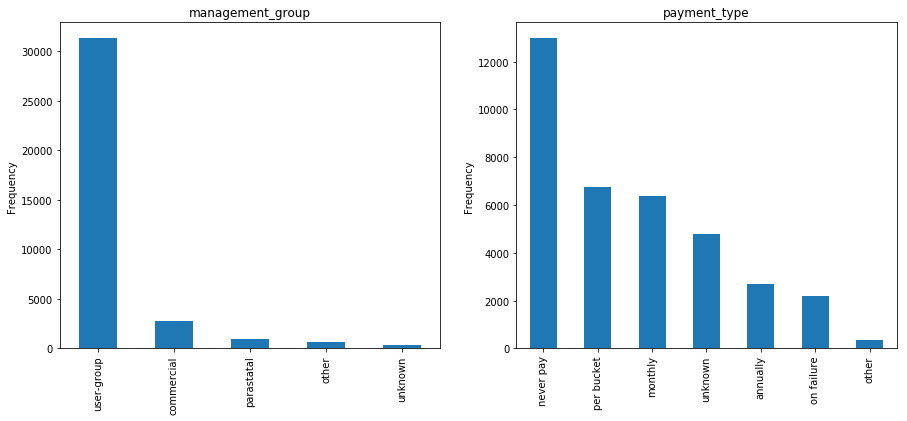

In [14]:
plot_two(df,'management_group','payment_type')


In [15]:
# management_group is way too unbalanced to be useful
df.drop('management_group',axis=1,inplace=True)

In [16]:
# we'll need to one-hot encode the payment_type field
df=pd.get_dummies(df,drop_first=False,columns=['payment_type'],prefix="payment")
# drop one column to avoid over-correlation
df.drop('payment_other',axis=1,inplace=True)

#### quality_group and quantity_group

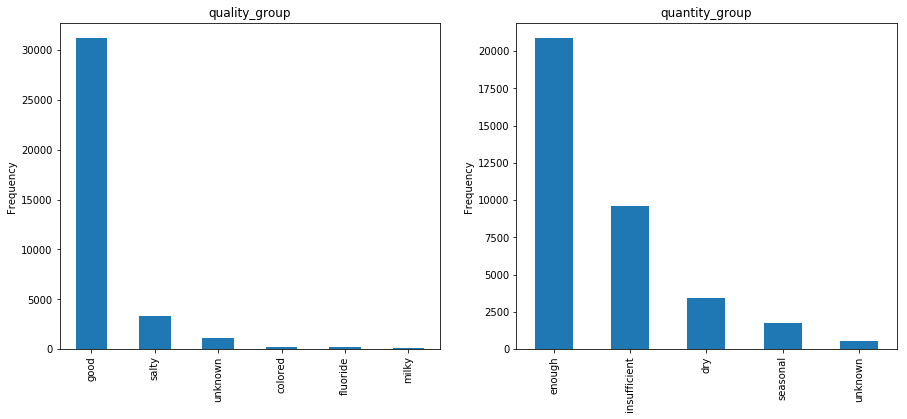

In [17]:
plot_two(df,'quality_group','quantity_group')


quality_group contains basically binary data, good and not good (salty, colored, milky), so let's binarize that field as a new field, quality

In [18]:
df.quality_group.value_counts()

good        31180
salty        3309
unknown      1158
colored       218
fluoride      167
milky         131
Name: quality_group, dtype: int64

In [19]:
def map_quality(q):
    if(q=="good"):
        return 1
    else:
        return 0
# create the new field:    
df['quality']=df.quality_group.map(map_quality)

# drop the original column:
df.drop('quality_group',axis=1,inplace=True)

quantity_group contains basically binary data, enough and not enough (insufficient, dry, seasonal), so let's binarize that field as a new field, quantity

In [20]:
df.quantity_group.value_counts()

enough          20844
insufficient     9614
dry              3425
seasonal         1773
unknown           507
Name: quantity_group, dtype: int64

In [21]:
def map_quantity(q):
    if(q=="enough"):
        return 1
    else:
        return 0
# create the new field:    
df['quantity']=df.quantity_group.map(map_quantity)

# drop the original column:
df.drop('quantity_group',axis=1,inplace=True)

#### source_type and source_class

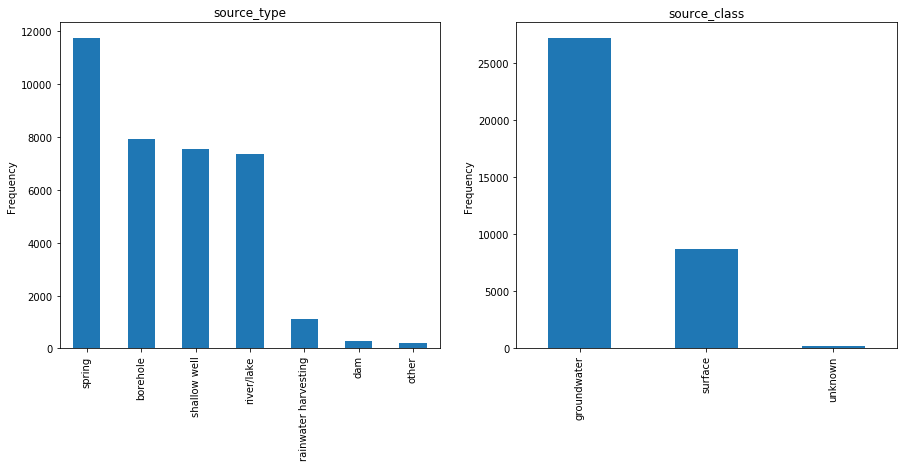

In [22]:
plot_two(df,'source_type','source_class')


source_type has a good distribution of categorical values, so let's one-hot encode those:


In [23]:
# one-hot encode the source_type field
df=pd.get_dummies(df,drop_first=False,columns=['source_type'],prefix="source")

# drop one of the encoded columns to avoid over-correlation:
df.drop('source_other',axis=1,inplace=True)

source_class (groundwater, surface) is a more general categorization of source_type (e.g., dam, spring, well) which contains all the information in it anyway. Let's drop source_class in favor of source_type.

In [24]:
df.drop('source_class',axis=1,inplace=True)

#### region_code and district_code

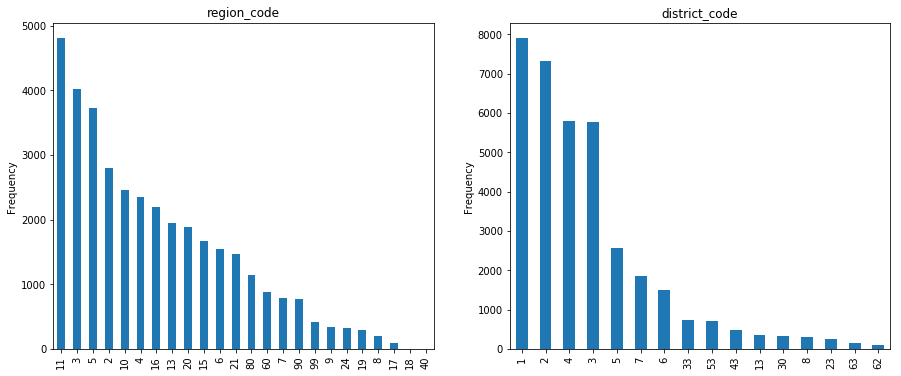

In [25]:
plot_two(df,'region_code','district_code')


Tanzania is divided into 31 regions, each of which is further divided into districts. \[[Regions of Tanzania](https://en.wikipedia.org/wiki/Regions_of_Tanzania)\] For our predictve purposes, let's use the 31 regions as our geographic measure.

In [26]:
# drop district_code in favor of using region_code
df.drop('district_code',axis=1,inplace=True)

Let's try a risk encoding of the 31 regions so we retain a single column of data with representative values (instead of one-hot encoding into multiple columns).

In [27]:
#copy risk code from notebook:
General_Prob = (df.status_group == 1).sum()/float(df.shape[0])
variable_risks = {}
for variable in ['region_code']:
    tab = pd.crosstab(df[variable], df.status_group)
    print(tab,"\n")
    num_levels = tab.shape[0]
    level_risk = {}
    levels = list(tab.index)
    level_index = 0
    for lev in levels:
        level_risk[lev] = np.log((tab.iloc[level_index, 1] + General_Prob) / (tab.iloc[level_index, 0] + 1 - General_Prob))
        level_index += 1
    variable_risks[variable] = level_risk

# list the risks associated with the variables
#variable_risks['region_code']

status_group     0     1
region_code             
2              860  1944
3             1398  2627
4              963  1384
5             1584  2139
6              512  1043
7              335   450
8              176    20
9              215   125
10             985  1475
11             928  3876
13             949  1008
15             966   705
16             847  1357
17              23    72
18               6     2
19             192    98
20            1014   879
21             494   981
24               9   312
40               1     0
60             482   402
80             716   425
90             579   191
99             225   189 



In [28]:
# assign these risk values to a new column, region:
df['region'] = df.region_code.map(variable_risks['region_code'])

# and drop the original column:
df.drop('region_code',axis=1,inplace=True)

#### waterpoint_type_group

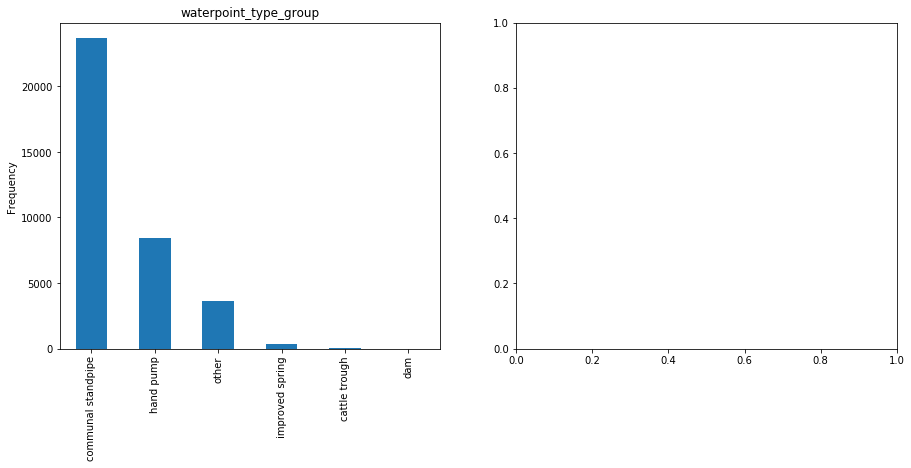

In [29]:
plot_two(df,'waterpoint_type_group')

This field has three main values (communal standpipe, hand pump and other) with a few remaining types. Let's fold those remaining types into the "other" category, and one-hot encode this field.

In [30]:
df.waterpoint_type_group.value_counts()

communal standpipe    23679
hand pump              8412
other                  3655
improved spring         334
cattle trough            78
dam                       5
Name: waterpoint_type_group, dtype: int64

In [31]:
def map_waterpoint(v):
    if(v not in ['communal standpipe','hand pump']):
        return 'other'
    else:
        return v
   
df['waterpoint_type_group']=df0.waterpoint_type_group.map(map_waterpoint)

# one-hot encode
df=pd.get_dummies(df,drop_first=False,columns=['waterpoint_type_group'],prefix="waterpoint")

# drop one of the encoded columns to avoid over-correlation:
df.drop('waterpoint_other',axis=1,inplace=True)

## Boolean fields
Here are the fields that are boolean. We'll look at these fields to get a sense of their distributions.

* public_meeting
* permit

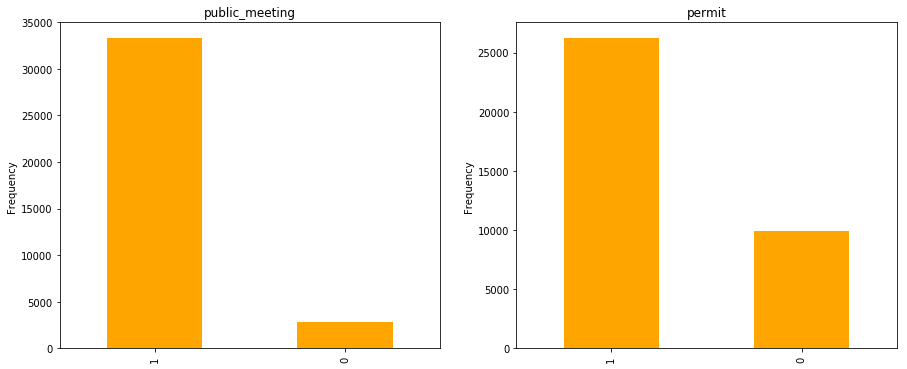

In [32]:
plot_two(df,'public_meeting','permit',color='orange')

The permit field has a moderate split between true and false. The public_meeting field looks much more lopsized; we'll keep an eye on this field going forward.

## Geographic fields
Here are the fields that are geographic. 

* latitude
* longitude

We used these fields to join the precipitation data to the water pump data. Neither of these continuously numeric values is important for prediction. The geographic data are already captured in region_code at a level that makes sense for predictions, so we can drop these two fields.

If we need these values later, we can use the backup data copy, df0.

In [33]:
df.drop('latitude',axis=1,inplace=True)
df.drop('longitude',axis=1,inplace=True)

## Scaling
Now let's apply scaling to features that aren't already on the 0-1 scale.

In [34]:
df.describe().loc[:,df.describe().loc['max']!=1]

gps_height    population           age        precip        region
count  36163.000000  36163.000000  36163.000000  36163.000000  36163.000000
mean     998.261842    309.320300     15.226779      0.975018      0.445591
std      625.295640    649.613378     12.484459      1.058515      0.662901
min      -63.000000     10.000000     -7.000000     -2.054734     -2.147454
25%      358.500000     50.000000      4.000000      0.657526      0.060489
50%     1153.000000    150.000000     13.000000      1.189198      0.403773
75%     1492.000000    250.000000     25.000000      1.650713      0.711326
max     2628.000000   3500.000000     53.000000      2.875368      3.504234

We'll apply scaling approaches appropriate for each of these five features:

MinMax (0-1):  
* population

StandardScale:  
* gps_height
* age
* precip
* region

In [35]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

MinMax scale the population field

In [36]:
scaler1 = MinMaxScaler()
df['population']=scaler1.fit_transform(df.population.astype('float').values.reshape(-1, 1))[:,0]

Standard Scale the other four continuous fields

In [37]:
scaler2 = StandardScaler()
fields_to_transform = ['gps_height','age','precip','region']
trans = scaler2.fit_transform(df[fields_to_transform])

# re-assign scaled values into the correct column:
for i,f in enumerate(fields_to_transform):
    df[f] = trans[:,i]

## Target field
Let's also have a look at the distribution of the dependent variable to complete the picture.

Currently the target field, status_group, is encoded:

* 0=not working
* 1=working

Since we are focused on predicting the "not working" state, let's flip the encoding of these values:

* 0=working
* 1=not working

Therefore, our modeling becomes a predictor of which pumps **are not working** which is the most important outcome.

In [38]:
df.status_group=df.status_group.map({0:1,1:0})

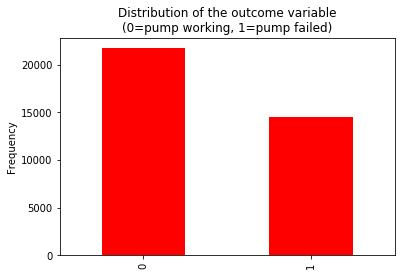

In [39]:
df.status_group.value_counts().sort_index().plot(kind='bar',color='red')
plt.title("Distribution of the outcome variable\n(0=pump working, 1=pump failed)")
plt.ylabel("Frequency")
_=""

We have a reasonable balance of working and non-working outcomes in our dataset.

## Data summary
After analyzing the continuous, categorical and boolean independent variables and applying one-hot encoding, risk calculations, feature creation and binning, here is our dataset:

In [40]:
df.head()

gps_height  population  public_meeting  permit  status_group       age  \
0   -0.309077    0.212034               0       1             1  2.144554   
1   -0.344261    1.000000               1       1             0 -0.979373   
2   -0.344261    1.000000               0       1             1  2.144554   
3   -0.328268    0.000000               0       1             1  2.144554   
4   -0.344261    0.040115               1       1             1 -0.819172   

     precip  basin_Internal  basin_Lake Nyasa  basin_Lake Tanganyika  \
0  0.923499               0                 0                      1   
1  0.923499               0                 0                      1   
2  0.923499               0                 0                      1   
3  0.923499               0                 0                      1   
4  0.923499               0                 0                      1   

           ...           quantity  source_borehole  source_dam  \
0          ...                  0                0           0   
1          ...                  1                0           0   
2          ...                  0                0           0   
3          ...                  0                0           0   
4          ...                  0                0           0   

   source_rainwater harvesting  source_river/lake  source_shallow well  \
0                            0                  1                    0   
1                            0                  0                    1   
2                            0                  1                    0   
3                            0                  1                    0   
4                            0                  0                    0   

   source_spring    region  waterpoint_communal standpipe  \
0              0  0.038785                              1   
1              0  0.038785                              0   
2              0  0.038785                              1   
3              0  0.038785                              1   
4              1  0.038785                              1   

   waterpoint_hand pump  
0                     0  
1                     1  
2                     0  
3                     0  
4                     0  

[5 rows x 38 columns]

In [41]:
df.describe()

gps_height    population  public_meeting        permit  status_group  \
count  3.616300e+04  36163.000000    36163.000000  36163.000000  36163.000000   
mean  -8.857101e-17      0.085765        0.921190      0.725686      0.399829   
std    1.000014e+00      0.186136        0.269445      0.446174      0.489870   
min   -1.697240e+00      0.000000        0.000000      0.000000      0.000000   
25%   -1.023149e+00      0.011461        1.000000      0.000000      0.000000   
50%    2.474674e-01      0.040115        1.000000      1.000000      0.000000   
75%    7.896185e-01      0.068768        1.000000      1.000000      1.000000   
max    2.606384e+00      1.000000        1.000000      1.000000      1.000000   

                age        precip  basin_Internal  basin_Lake Nyasa  \
count  3.616300e+04  3.616300e+04    36163.000000      36163.000000   
mean  -1.888788e-15  1.497406e-14        0.119763          0.071537   
std    1.000014e+00  1.000014e+00        0.324689          0.257724   
min   -1.780380e+00 -2.862306e+00        0.000000          0.000000   
25%   -8.992728e-01 -2.999453e-01        0.000000          0.000000   
50%   -1.783665e-01  2.023428e-01        0.000000          0.000000   
75%    7.828418e-01  6.383511e-01        0.000000          0.000000   
max    3.025661e+00  1.795323e+00        1.000000          1.000000   

       basin_Lake Tanganyika          ...               quantity  \
count           36163.000000          ...           36163.000000   
mean                0.082239          ...               0.576390   
std                 0.274732          ...               0.494137   
min                 0.000000          ...               0.000000   
25%                 0.000000          ...               0.000000   
50%                 0.000000          ...               1.000000   
75%                 0.000000          ...               1.000000   
max                 1.000000          ...               1.000000   

       source_borehole    source_dam  source_rainwater harvesting  \
count     36163.000000  36163.000000                 36163.000000   
mean          0.218981      0.007577                     0.031137   
std           0.413561      0.086716                     0.173690   
min           0.000000      0.000000                     0.000000   
25%           0.000000      0.000000                     0.000000   
50%           0.000000      0.000000                     0.000000   
75%           0.000000      0.000000                     0.000000   
max           1.000000      1.000000                     1.000000   

       source_river/lake  source_shallow well  source_spring        region  \
count       36163.000000         36163.000000   36163.000000  3.616300e+04   
mean            0.203274             0.208252       0.325167 -3.867274e-14   
std             0.402440             0.406063       0.468444  1.000014e+00   
min             0.000000             0.000000       0.000000 -3.911715e+00   
25%             0.000000             0.000000       0.000000 -5.809429e-01   
50%             0.000000             0.000000       0.000000 -6.308496e-02   
75%             0.000000             0.000000       1.000000  4.008727e-01   
max             1.000000             1.000000       1.000000  4.614088e+00   

       waterpoint_communal standpipe  waterpoint_hand pump  
count                   36163.000000          36163.000000  
mean                        0.654785              0.232613  
std                         0.475445              0.422504  
min                         0.000000              0.000000  
25%                         0.000000              0.000000  
50%                         1.000000              0.000000  
75%                         1.000000              0.000000  
max                         1.000000              1.000000  

[8 rows x 38 columns]

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36163 entries, 0 to 57587
Data columns (total 38 columns):
gps_height                       36163 non-null float64
population                       36163 non-null float64
public_meeting                   36163 non-null int64
permit                           36163 non-null int64
status_group                     36163 non-null int64
age                              36163 non-null float64
precip                           36163 non-null float64
basin_Internal                   36163 non-null uint8
basin_Lake Nyasa                 36163 non-null uint8
basin_Lake Tanganyika            36163 non-null uint8
basin_Lake Victoria              36163 non-null uint8
basin_Pangani                    36163 non-null uint8
basin_Rufiji                     36163 non-null uint8
basin_Ruvuma / Southern Coast    36163 non-null uint8
basin_Wami / Ruvu                36163 non-null uint8
type_gravity                     36163 non-null uint8
type_handpump      

Save out our final dataset now. This will be the input to the next milestone (M03).

In [43]:
f_out = 'data/LoganDowning-M02-dataset.csv'

# uncomment to save out the file:
#df.to_csv(f_out,index=None)

# Step 3. Feature selection
Now that we have our final dataset, let's have a look at the individual features and their likely contributions to predictive power. We'll first do a correlation analysis first using Pearson's product-moment. Then we'll use three different feature selection approaches see if we can come up with the optimal set of features to use for the machine learning.

## Correlation analysis
First let's have a look at the 37 features and how they correlate with each other and with the target variable. Here is a heatmap of the features having the strongest correlations.

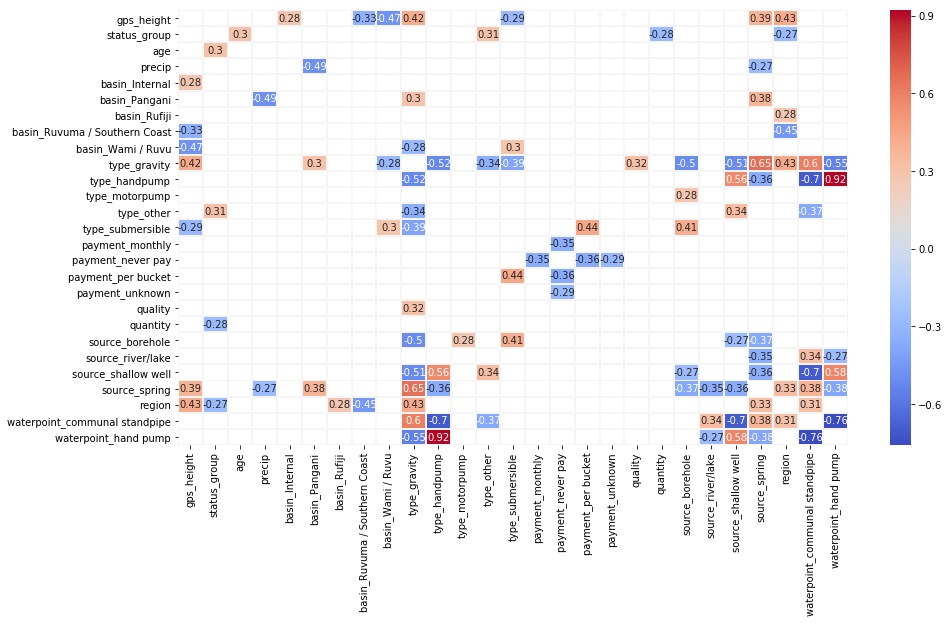

In [44]:
corr=df.corr()
plt.figure(figsize=(15,8))

# plot features having significant correlations with other features
min = .27
max = 1
annot=True
mycorr = corr[ (np.abs(corr)>=min) & (np.abs(corr)<max) ].dropna(axis=0,how='all').dropna(axis=1,how='all')

# Generate a mask for the upper triangle
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
mask = np.zeros_like(mycorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask=False

sns.heatmap( mycorr, cmap='coolwarm', annot=annot, mask=mask,linewidths=1,linecolor=(.96,.96,.96))
_=""

#### Waterpoint variables are (too) highly correlated

The first thing that stands out is that two features are extremely correlated with type_handpump:

* waterpoint_hand pump (.92)
* waterpoint_communal standpipe (-.70)

This makes sense: each is encoding whether the pump involves a hand pump. We'll omit the two waterpoint features in favor of the type_handpump field, which conveys the same information.

In [45]:
# drop the duplicative fields:
df.drop('waterpoint_hand pump',axis=1,inplace=True)
df.drop('waterpoint_communal standpipe',axis=1,inplace=True)

#### Fields most highly correlated with outcome
Looking at the status_group target variable, we can see that the following features are more correlated with it (as compared to the other features):

* **region (-.27)**  
A correlation here makes sense, since we are using risk scores for the region values.
* **quantity (-.28)**  
The interpretation is that pumps with a sufficient yearly availability (high quantity) tend towards the working state. Non-functioning pumps are more associated with pumps with sporadic availability (dry, seasonal or insufficient).
* **type_other (.31)**  
Pumps of types other than the main ones (gravity, hand pump, submersibles, etc.) are those that tend to be non-functional.
* **age (.30)**  
Pumps that are older tend to be the ones that are non-functioning.

#### "type" fields and "source" fields show correlations
Note that the type fields (gravity, handpump, submersible, etc.) show some reasonably strong correlations with the source fields (borehold, river/lake, shallow well). This makes sense, since the method of extraction is likely tied to the source of the water. Instead of omitting one or the other, though, let's keep both categories in the mix and see how our feature selection goes; I'll be most interested in how Lasso performs on these fields.

## Feature selection using Decision Trees
In this section we'll use a Random Forest approach to determine the best features to use for modeling. We'll emply its "feature importances" attribute.

### Test, train, validation split
We'll need to establish our train & validation, and test datasets, which carry through to all subsequent feature selection, modeling and evaluation work.

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X = df.drop('status_group',axis=1) # status_group is the outcome variable
y = df.status_group

# first split out a test set (X_test, y_test)
X_rest,X_test,y_rest,y_test = train_test_split(X,y,test_size=.2,random_state=101)

# now split a validation set out of the remaining data
X_train,X_validate,y_train,y_validate = train_test_split(X_rest,y_rest,test_size=.25,random_state=102)


In [48]:
# check on the sizes of each of the three sets of data
print("Size of training: {} ({}% of total)".format(  len(X_train), round(len(X_train)/len(X)*100,0)       ))
print("Size of validate: {} ({}% of total)".format(  len(X_validate), round(len(X_validate)/len(X)*100,0)       ))
print("Size of test: {} ({}% of total)".format(  len(X_test), round(len(X_test)/len(X)*100,0)       ))


Size of training: 21697 (60.0% of total)
Size of validate: 7233 (20.0% of total)
Size of test: 7233 (20.0% of total)


### Random Forest feature selection
Use a Random Forest to find the features it considers the most important in predicting outcomes. We'll stick largely with defaults here, as we aren't yet using Random Forest as the final modelling approach, just using it to determine features.

In [49]:
from sklearn.ensemble import RandomForestClassifier
m = RandomForestClassifier(n_estimators=100,random_state=103)

In [50]:
# fit on the training data
m.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=103, verbose=0, warm_start=False)

Assess the accuracy of the Random Forest to know whether to trust its feature importances.

In [51]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support as score, classification_report, confusion_matrix

# predict on the validate data
y_pred = m.predict(X_validate)

precision, recall, fscore, support = score(y_validate,y_pred,average='weighted')
print("Classification report\n\n",classification_report(y_validate,y_pred))

print("Overall accuracy {:.1f}%".format( accuracy_score(y_validate,y_pred)*100 ))
print("Overall F1-score {:.1f}%".format( fscore*100 ))

Classification report

              precision    recall  f1-score   support

          0       0.85      0.88      0.86      4381
          1       0.80      0.76      0.78      2852

avg / total       0.83      0.83      0.83      7233

Overall accuracy 83.1%
Overall F1-score 83.1%


The performance of the Random Forest approach is pretty good. Let's interrogate which features it suggests are most predictive.

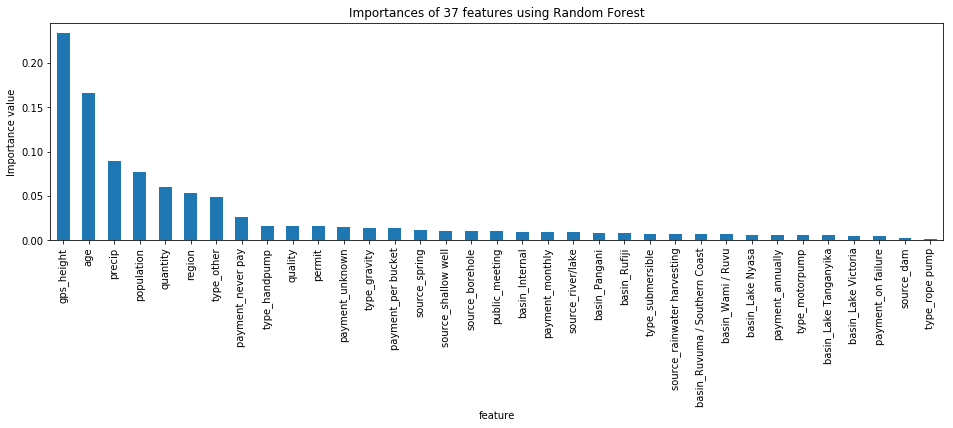

In [52]:
ax=plt.figure(figsize=(16,4)).gca()
plt.ylabel("Importance value")
plt.title("Importances of 37 features using Random Forest")
pd.DataFrame({'feature':X.columns.values, 'importance':m.feature_importances_})\
    .set_index('feature').sort_values(by='importance',ascending=False).plot(kind='bar',ax=ax, legend=None)
_=''

According to Random Forest importances, the features most highly predictive of pump state are:

* gps_height
* age
* precip
* population
* quantity
* region
* type_other
* payment_never pay

## Lasso regression feature selection
Next let's compare to the features that Lasso modelling believes are most predictive.

In [53]:
from sklearn import linear_model

In [54]:
# I grid tested the value of alpha to come up with about 8 non-zero features
alpha = 0.015
m = linear_model.Lasso(alpha=alpha, random_state=104)
m.fit(X_train,y_train)

Lasso(alpha=0.015, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=104,
   selection='cyclic', tol=0.0001, warm_start=False)

In [55]:
lasso_df = pd.DataFrame({'feature':X.columns.values, 'coef':m.coef_})
print("Features with the largest positive coefficients\n\n",lasso_df.sort_values(by='coef',ascending=False).head(7))
print("\n\nFeatures with the largest negative coefficients\n\n",lasso_df.sort_values(by='coef',ascending=False).tail(7))

Features with the largest positive coefficients

               feature      coef
17         type_other  0.170134
4                 age  0.105365
22  payment_never pay  0.076374
25    payment_unknown  0.041298
16     type_motorpump  0.000000
29         source_dam  0.000000
28    source_borehole  0.000000


Features with the largest negative coefficients

                         feature      coef
3                        permit -0.000000
2                public_meeting -0.000000
30  source_rainwater harvesting -0.000000
0                    gps_height -0.010344
14                 type_gravity -0.046482
34                       region -0.054624
27                     quantity -0.139881


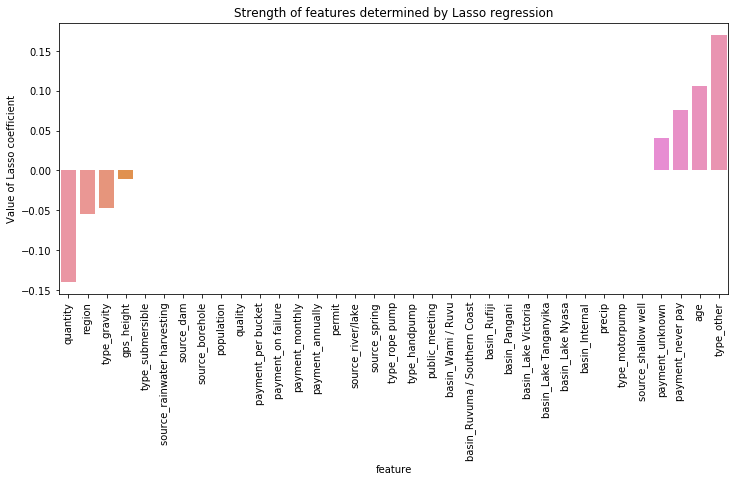

In [56]:
ax=plt.figure(figsize=(12,5)).gca()
plt.xticks(rotation=90)
plt.title("Strength of features determined by Lasso regression")

sns.barplot(data=lasso_df.sort_values(by='coef'),x='feature',y='coef',ax=ax)
plt.ylabel("Value of Lasso coefficient")
_=''

According to the Lasso regression, the following features are of primary importance:

* **type_other**
* **quantity **
* **age **
* **payment_never pay** 
* **region **
* type_gravity
* payment_unknown 
* **gps_height**  



The feaures in bold are those also predicted by the Random Forest model. There is much agreement between the two feature selection approaches.

Referring back to our correlation analysis, all bolded fields except gps_height were predicted to be highly relevant to the predictive outcome, so it looks like we are on track.



## Backwards stepwise feature selection
Finally let's run a backwards stepwise feature selection model just to compare this third method with the previous two.

In [57]:
# Recursive Feature Elimination
from sklearn.feature_selection import RFE #Recursive Feature Elimination
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression()

# keep the top 8 features:
n_keep = 8
selector = RFE(estimator, n_keep, step=1,verbose=0) # remove 1 at a time
selector = selector.fit(X_rest, y_rest)         # fit over train + validate sets  
print("Selectors retained:\n", X_rest.columns.values[selector.support_])             # show which are kept (True) and which are removed (False)
#print(selector.ranking_)             # order of removal (1=kept)

Selectors retained:
 ['type_other' 'payment_unknown' 'quantity' 'source_borehole' 'source_dam'
 'source_river/lake' 'source_shallow well' 'source_spring']


The recursive backwards step algorithm picked out two of the features also tagged as being most important:

* type_other
* quantity

The other features it designated are related to water source:

* source_borehole
* source_dam
* source_river/lake
* source_shallow well
* source_spring

and a non-source feature:

* payment_unknown

In this case we'll stick with majority wins, and accept the features also identified by the other two approaches (type_other and quantity).

## Feature selection summary - Primary features
From running three different feature selection approaches, we expect the following fields to be most highly predictive of the target:

* type_other
* quantity
* age
* region
* payment_never pay
* gps_height

The first two fields (type_other and quantity) were picked out by all three approaches. The remaining were identified by two of the approaches.



# Step 4. Baseline modeling
To summarize where we are, we have:

* Read in our dataset and applied feature engineering, using binning, risk scoring, log transformations and one-hot encoding.

* Divided our data into three groups: training, validation and test.

* Used feature selection approaches to determine the "best" features that we think are most predictive of outcomes.

We're now ready to perform our baseline modeling. In this section we'll apply three different machine learning approaches and compare performance based on the training and validation datasets. 


#### Goal
The goal is to determine which model approach looks most favorable to highest performance. If we can determine a clear winner, we'll start with that model in the next milestone (M03) and optimize it.

#### Baseline modeling using defaults
For the purposes of this milestone (M02), we'll use default parameters (when needed) when constructing our three models. In the last milestone (M03) we'll enhance this work using grid search and hyperparameter tuning to improve our results and come up with our production model.

## Logistic Regression
Let's explore a classic Logistic Regression model on our training and validation data. As agreed we use model parameter defaults in this section.

In [58]:
clf_lr = LogisticRegression(random_state=201)

### Overall cross-validated AUC score
Let's use cross-validation to determine a baseline AUC score for Logistic Regression. We'll follow this up with deeper analysis on training and validation separately.

In [59]:
from sklearn.model_selection import cross_val_score

# apply cross-validation to the "rest" data, which is training + validation
scores = cross_val_score( clf_lr,X_rest,y_rest,scoring='roc_auc',cv=10 )
print("Average score: {:.2f}".format(scores.mean()))

Average score: 0.81


### Model using all 35 features
We'll start with the entire set of 35 features. See the next section for modeling with the six features deemed most predictive.

In [60]:
clf_lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=201, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Create predictions for both the training data and the validation data. Comparing these will let us evaluate the extent of possible overfitting.

In [61]:
y_pred_train = clf_lr.predict(X_train)
y_pred_valid = clf_lr.predict(X_validate)

Now examine the performance on the training dataset

In [62]:
from sklearn.metrics import auc,roc_curve
def perf_summary(y_true,y_pred,y_prob=None,dataset=''):   

    # y_true = actual class label
    # y_pred = predicted class label
    # y_prob = probability of class membership, used in auc (send in null for n/a)
    # dataset = a label, e.g., "training" or "validation" that will be printed out
    
    # classification report:
    print("Classification report for {} data:\n".format(dataset))
    print(classification_report(y_true,y_pred))

    # accuracy:
    print("Overall accuracy: {:.2f}".format(accuracy_score(y_true,y_pred)))
    
    # auc:
    if y_prob is not None:
        fpr,tpr,th = roc_curve(y_true,y_prob,pos_label=1)
        auc_score = auc(fpr,tpr)
        print("\nAUC score: {:.2f}".format(auc_score))
    
perf_summary(y_train,y_pred_train,dataset='training')

Classification report for training data:

             precision    recall  f1-score   support

          0       0.76      0.85      0.80     12970
          1       0.73      0.60      0.66      8727

avg / total       0.75      0.75      0.74     21697

Overall accuracy: 0.75


And look at the the performance on the validation dataset

In [63]:
y_prob = clf_lr.predict_proba(X_validate)[:,1] # prob of class 1
perf_summary(y_validate,y_pred_valid,y_prob,dataset='validation')

Classification report for validation data:

             precision    recall  f1-score   support

          0       0.77      0.83      0.80      4381
          1       0.71      0.62      0.66      2852

avg / total       0.75      0.75      0.75      7233

Overall accuracy: 0.75

AUC score: 0.81


Performance on the positive class (pump not working) is in the 66% range (F1 score for class 1), with recall around 60-62% and precision at about 71%. Both train and validate are similarly scored, so we expect the Logistic Regression model to generalize well.

### Model using best six features
And let's compare to a Logistic Regression model using just the six features selected earlier.

In [64]:
best_features = [
    'type_other',
    'quantity',
    'age',
    'region',
    'payment_never pay',
    'gps_height'
]

clf_lr_best = LogisticRegression(random_state=210)
clf_lr_best.fit(X_train[best_features],y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=210, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Create predictions for both the training data and the validation data. 

In [65]:
y_pred_train_best = clf_lr_best.predict(X_train[best_features])
y_pred_valid_best = clf_lr_best.predict(X_validate[best_features])

Examine the performance on the training dataset...

In [66]:
perf_summary(y_train,y_pred_train_best,dataset='training')

Classification report for training data:

             precision    recall  f1-score   support

          0       0.73      0.84      0.78     12970
          1       0.70      0.54      0.61      8727

avg / total       0.72      0.72      0.71     21697

Overall accuracy: 0.72


...and the performance on the validation dataset

In [67]:
y_prob_ = clf_lr_best.predict_proba(X_validate[best_features])[:,1] # prob of class 1
perf_summary(y_validate,y_pred_valid_best,y_prob,dataset='validation')

Classification report for validation data:

             precision    recall  f1-score   support

          0       0.75      0.84      0.79      4381
          1       0.70      0.57      0.63      2852

avg / total       0.73      0.73      0.73      7233

Overall accuracy: 0.73

AUC score: 0.81


Under the limited-feature approach the model provided about 61-63% performance (F1 score for the positive class), with no detectable overfitting between training and validate datasets. Recall was around 57% with precision about 70%.

### Performance summary: Logistic Regression
A simple Logistic Regression model using the entire set of 35 features performs better than that using just the top six predicted best features. (Note we are using model parameter defaults.) The F1 score for the positive class is about 66%, with recall being the worst measure at about 62%. Precision hovers around 71%. AUC score was 0.81.

## Support Vector Machine
Let's apply an SVM classifier model to our training data. As agreed we use model parameter defaults during this section.

In [68]:
from sklearn.svm import SVC
clf_svm = SVC(random_state=220, probability=False) # computing the probabilities takes forever, so set that to False

### Overall cross-validated AUC score
Let's use cross-validation to determine a baseline AUC score for SVM. We'll follow this up with deeper analysis on training and validation separately.

In [69]:
# apply cross-validation to the "rest" data, which is training + validation
#scores = cross_val_score( clf_svm,X_rest,y_rest,scoring='roc_auc',cv=10 )
#print("Average score: {:.2f}".format(res.mean()))

Turns out SVM takes forever to run, even with just 10-fold cross-validation on just a few thousand datapoints. We'll omit AUC for this model.

### Model using all 35 features
We'll start with the entire set of features. See the next section for modeling with the six features deemed most predictive.

In [70]:
time0=time()
clf_svm.fit(X_train,y_train)
print("Time elapsed: {:.1f} seconds".format(time()-time0))

Time elapsed: 50.6 seconds


Create predictions for both the training data and the validation data. Comparing these will let us evaluate the extent of possible overfitting.

In [71]:
time0=time()

# training data:
y_pred_train = clf_svm.predict(X_train)
print("Time elapsed: {:.1f} seconds".format(time()-time0))

# validation data:
y_pred_valid = clf_svm.predict(X_validate)

Time elapsed: 24.0 seconds


Now examine the performance on the training dataset

In [72]:
perf_summary(y_train,y_pred_train,dataset='training')

Classification report for training data:

             precision    recall  f1-score   support

          0       0.77      0.90      0.83     12970
          1       0.80      0.60      0.69      8727

avg / total       0.78      0.78      0.77     21697

Overall accuracy: 0.78


And look at the the performance on the validation dataset

In [73]:
perf_summary(y_validate,y_pred_valid,dataset='validation')

Classification report for validation data:

             precision    recall  f1-score   support

          0       0.78      0.89      0.83      4381
          1       0.78      0.60      0.68      2852

avg / total       0.78      0.78      0.77      7233

Overall accuracy: 0.78


Performance on the positive class (pump not working) is in the 68% range (F1 score for class 1), with recall around 60% and precision at 78%. Note that both train and validate are similarly scored, so we expect the SVM model to generalize well.

### Model using best six features
And let's compare to a SVM model using just the six features selected earlier.

In [74]:
clf_svm_best = SVC(random_state=221,probability=True)
clf_svm_best.fit(X_train[best_features],y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=221, shrinking=True,
  tol=0.001, verbose=False)

Create predictions for both the training data and the validation data. 

In [75]:
y_pred_train_best = clf_svm_best.predict(X_train[best_features])
y_pred_valid_best = clf_svm_best.predict(X_validate[best_features])

Examine the performance on the training dataset...

In [76]:
perf_summary(y_train,y_pred_train_best,dataset='training')

Classification report for training data:

             precision    recall  f1-score   support

          0       0.74      0.87      0.80     12970
          1       0.74      0.54      0.63      8727

avg / total       0.74      0.74      0.73     21697

Overall accuracy: 0.74


...and the performance on the validation dataset

In [77]:
perf_summary(y_validate,y_pred_valid_best,dataset='validation')

Classification report for validation data:

             precision    recall  f1-score   support

          0       0.75      0.87      0.81      4381
          1       0.74      0.57      0.64      2852

avg / total       0.75      0.75      0.74      7233

Overall accuracy: 0.75


Under the limited-feature approach the model provided about 64% performance (F1 score for the positive class), with no detectable overfitting between training and validate datasets. Recall was around 57% with precision about 74%.

### Performance summary: SVM
An SVM model using the entire set of 35 features performs better than that using just the top six predicted best features. (Note we are using model parameter defaults.) The F1 score for the positive class is about 68%, with recall being the worst measure at about 60%. Precision hovers around 78%.

These results compare favorably to the Logistic Regression approach, which offers a similar F1 score (66%), a recall score of 62% and precision of 71%.

## CART (Decision Tree)
Let's apply an Random Forest classifier model to our training data. As agreed we use mostly model parameter defaults during this section.

In [78]:
clf_rf = RandomForestClassifier(random_state=230, n_estimators=50, n_jobs=-1)

### Overall cross-validated AUC score
Let's use cross-validation to determine a baseline AUC score for CART. We'll follow this up with deeper analysis on training and validation separately.

In [79]:
# apply cross-validation to the "rest" data, which is training + validation
scores = cross_val_score( clf_rf,X_rest,y_rest,scoring='roc_auc',cv=10 )
print("Average score: {:.2f}".format(scores.mean()))

Average score: 0.90


### Model using all 35 features
We'll start with the entire set of 35 features. See the next section for modeling with the six features deemed most predictive.

In [80]:
clf_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=230, verbose=0, warm_start=False)

Create predictions for both the training data and the validation data. Comparing these will let us evaluate the extent of possible overfitting.

In [81]:
y_pred_train = clf_rf.predict(X_train)
y_pred_valid = clf_rf.predict(X_validate)

Now examine the performance on the training dataset

In [82]:
perf_summary(y_train,y_pred_train,dataset='training')

Classification report for training data:

             precision    recall  f1-score   support

          0       0.99      1.00      1.00     12970
          1       1.00      0.99      0.99      8727

avg / total       1.00      1.00      1.00     21697

Overall accuracy: 1.00


And look at the the performance on the validation dataset

In [83]:
y_prob = clf_rf.predict_proba(X_validate)[:,1] # prob of class 1
perf_summary(y_validate,y_pred_valid,y_prob,dataset='validation')

Classification report for validation data:

             precision    recall  f1-score   support

          0       0.85      0.88      0.86      4381
          1       0.80      0.75      0.78      2852

avg / total       0.83      0.83      0.83      7233

Overall accuracy: 0.83

AUC score: 0.90


Performance on the positive class (pump not working) is in the 78% range (F1 score for class 1), with recall around 75% and precision at 80%. AUC score was .86.

Note that the performance for training is near-perfect (99% F1) score, indicating we are strongly overfitting the training data. 

### Model using best six features
And let's compare to a Random Forest model using just the six features selected earlier.

In [84]:
clf_rf_best = RandomForestClassifier(random_state=231, n_estimators=50)
clf_rf_best.fit(X_train[best_features],y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=231, verbose=0, warm_start=False)

Create predictions for both the training data and the validation data. 

In [85]:
y_pred_train_best = clf_rf_best.predict(X_train[best_features])
y_pred_valid_best = clf_rf_best.predict(X_validate[best_features])

Examine the performance on the training dataset...

In [86]:
perf_summary(y_train,y_pred_train_best,dataset='training')

Classification report for training data:

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     12970
          1       0.98      0.98      0.98      8727

avg / total       0.99      0.99      0.99     21697

Overall accuracy: 0.99


...and the performance on the validation dataset

In [87]:
y_prob = clf_rf_best.predict_proba(X_validate[best_features])[:,1] # prob of class 1
perf_summary(y_validate,y_pred_valid_best,y_prob,dataset='validation')

Classification report for validation data:

             precision    recall  f1-score   support

          0       0.82      0.83      0.83      4381
          1       0.74      0.72      0.73      2852

avg / total       0.79      0.79      0.79      7233

Overall accuracy: 0.79

AUC score: 0.86


Under the limited-feature approach the model provided about 73% performance (F1 score for the positive class). Recall was around 72% with precision about 74%. AUC score was 0.86.

### Performance summary: Decision Tree
An Random Forest ensemble model using the entire set of 35 features performs better than that using just the top six predicted best features. (Note we are using model parameter defaults.) The F1 score for the positive class is about 78%, with recall being the worst measure at about 75%. Precision hovers around 80%. The AUC score is 0.86.

These results handily exceed those of both the Logistic Regression and SVM approaches. 

Because of the extreme overfitting observed in the Random Forest approach, it's very likely we'll be able to tune the hyperparameters in the next milestone (M03) to improve generalization of this model to unseen data.

# Step 5. Model performance evaluation
We examined three potential model approaches, Logistic Regression, SVM and Decision Tree. We used training data to create the models, and estimated performance using the validation dataset. 

#### Reduced feature set perform
In each of the three model approaches, the full set of 35 features performed slightly better than models using a reduced 6-feature sets. This suggests that our original list of six could be expanded to include additional features.

#### Performance metrics 
Performance metrics for the three model approaches using the full set of 35 features are shown in the following table.

Model | F1 | Recall | Precision | AUC | Overfitting?
-|-
Logistic Regression | .66 | .62 | .71 | .81 | No
SVM | .68 | .60 | .78 | Timeout | No
Decision Tree | .78 | .75 | .80 | .86 | Strong

The performance values are for the positive class, status_group=1, which signifies non-working water pumps. The values are calculated on the validation dataset.

#### Best model
It's clear the Decision Tree approach has the best chance to provide superior predictions. In each category (F1, recall and precision) the Decision Tree values exceed those of SVM and Logistic Regression. We note that the Decision Tree model is strongly overfitting on the training data even while providing solid predictive performance. This suggests we may be able to tune the Decision Tree model (among other improvements) to provide even better performance.

In [88]:
# get overall time to complete entire notebook
print("Time elapsed: {:.1f} seconds".format(time()-time00))

Time elapsed: 262.9 seconds


# Step 6. Model improvement plan
We select CART (Decision Tree) as the model best able to predict outcomes. Its performance using untuned parameters and a Random Forest approach is reasonable (F1 score nearly 80%, AUC at 0.84), and we might be able to improve. Here's our plan:

### 1. Reduce overfitting
As we saw the Decision Tree is strongly overfitting on the training dataset (performances in the upper 90%'s). Overfitting on training will result in poorer performance on unseen data. We will take steps to reduce the amount of overfitting including:

* **Hyperparameter tuning.** We'll conduct a grid search over sets of hyperparameters to find a balance between overfitting on training and generalization to unseen data. Typically we try parameters that apply a tree maximum depth, number of trees in the ensemble, and minimum number of samples before allowing splitting.

* **Revisit reduced features.** In this work we found that model performance for a reduced "best" set of features wasn't better for unseen data than the full feature set. It's worth taking another look at this to see whether we can spot patterns and possibly find an optimum reduced set of features that will generalize better.

### 2. Apply boosting algorithms 
We have two approaches to improving performance iteratively by concentrating on and modeling the errors from previous iterations.

* **Gradient Boosting** where the algorithm models the actual classification errors between interations, and 
* **AdaBoost** which more strongly samples those points incorrectly classified in previous iterations.

### 3. Add timing metrics
Model classification performance is important, but so is the time required to produce those results (as we saw with SVM fit/predict runtimes in this milestone). We'll add timing benchmarks to the fit and predict methods of our final model to get an expectation on how long those phases will take.



Please look for Milestone 3 and our tuned, optimized and final modeling work.

<p style="text-align:center;padding:4rem 4rem;border-top:1px silver solid">“Since when," he asked,
"are the first line and last line of any poem
where the poem begins and ends?” <br><br>

--<a href="https://www.goodreads.com/quotes/7217955-since-when-he-asked-are-the-first-line-and-last">Seamus Heaney</a>

</p>